## Bibliotecas

In [20]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

## Funções

In [21]:
# Binarização dos blocos via método ExG
def binarize_image_exg(img):
    
    B, G, R = cv2.split(img)
    # Fórmula do ExG
    exg = 2 * G.astype(np.float32) - R.astype(np.float32) - B.astype(np.float32)
    # Normalização
    exg_normalized = cv2.normalize(exg, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Binariza a img através do threshold
    _, binary_img = cv2.threshold(exg_normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return binary_img

In [22]:
# Função para carregar as imagens e segmentações
def load_data(input_img_path, input_binary_img_path, img_size=(256, 256)):
    images = []
    masks = []
    for img_name in os.listdir(input_img_path):

        img_path = input_img_path + '\\' + img_name
        mask_path = input_binary_img_path + '\\' + img_name
        
        img = load_img(img_path, target_size=img_size)
        mask = load_img(mask_path, target_size=img_size)
        
        img = img_to_array(img) / 255.0
        mask = img_to_array(mask) / 255.0
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

## Leitura da imagem e divisão em blocos

In [23]:

# Caminhos de input e output
input_path = r"C:\Users\mathe\Desktop\BemAgro\dados\Orthomosaico_roi.tif"
output_path = r"C:\Users\mathe\Desktop\BemAgro\dados\blocos"
os.makedirs(output_path, exist_ok=True)

In [24]:
# Abrindo a imagem
image = Image.open(input_path)

In [25]:
# Tamanho dos blocos em pixels e coleta da largura a altura da imagem
block_size = 256
width, height = image.size

# Divisão da imagem em blocos
for x in range(0, width, block_size):
    for y in range(0, height, block_size):

        left = x
        upper = y
        right = min(x + block_size, width)
        lower = min(y + block_size, height)
        
        block = image.crop((left, upper, right, lower))

        block_filename = os.path.join(output_path, f"block_{x}_{y}.png")
        block.save(block_filename)

## Geração do dataset

In [26]:
# Retira-se os blocos que são "rebarbas" dos cortes
for filename in os.listdir(output_path):

    path = output_path + '\\' + filename

    with Image.open(path) as block_file:
        block_file_size = block_file.size

    if (block_file_size == (256, 256)):
        pass
    else:
        os.remove(path)

In [27]:
# Atualizando os diretórios
input_path = output_path
output_path = r"C:\Users\mathe\Desktop\BemAgro\dados\blocos_binarizados"
os.makedirs(output_path, exist_ok=True)

In [28]:
# Aplica a binarização
for filename in os.listdir(input_path):

    input_img_path = input_path + '\\' + filename
    img = cv2.imread(input_img_path)
    
    binary_img = binarize_image_exg(img)
    
    output_img_path = output_path + '\\' + filename
    cv2.imwrite(output_img_path, binary_img)

## Treinamento e validação da rede neural

In [29]:
# Carregando os inputs
input_img_path = r"C:\Users\mathe\Desktop\BemAgro\dados\blocos"
input_binary_img_path = r"C:\Users\mathe\Desktop\BemAgro\dados\blocos_binarizados"

images, masks = load_data(input_img_path, input_binary_img_path)

# Divisão dos dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [30]:
def build_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Decoder
    u1 = UpSampling2D((2, 2))(p3)
    u1 = concatenate([u1, c3])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = UpSampling2D((2, 2))(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    u3 = UpSampling2D((2, 2))(c5)
    u3 = concatenate([u3, c1])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c6)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_15[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_17[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ max_pooling2d_5[… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 512)              │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    589,952 │ concatenate_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_19[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 256)              │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │    147,520 │ concatenate_4[0]

 Total params: 2,113,635 (8.06 MB)

 Trainable params: 2,113,635 (8.06 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Treinamento do modelo
model_path = r"C:\Users\mathe\Desktop\BemAgro\model\best_model.keras"
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

history = model.fit(images, masks, validation_split=0.2, epochs=10, batch_size=8, callbacks=[checkpoint, early_stopping])


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.3116 - loss: 0.6446 
Epoch 1: val_loss improved from inf to 0.36213, saving model to C:\Users\mathe\Desktop\BemAgro\model\best_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 547s 12s/step - accuracy: 0.3106 - loss: 0.6430 - val_accuracy: 0.0373 - val_loss: 0.3621
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1656 - loss: 0.3753 
Epoch 2: val_loss improved from 0.36213 to 0.30518, saving model to C:\Users\mathe\Desktop\BemAgro\model\best_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 536s 12s/step - accuracy: 0.1701 - loss: 0.3753 - val_accuracy: 0.2224 - val_loss: 0.3052
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1284 - loss: 0.2356 
Epoch 3: val_loss improved from 0.30518 to 0.17589, saving model to C:\Users\mathe\Desktop\BemAgro\model\best_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 545s 12s/step - accuracy: 0.1288 - loss: 0.2351 - val_accuracy: 0.1499 - val_loss: 0.1759
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step - accuracy: 0.1511 - loss: 0.1424
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


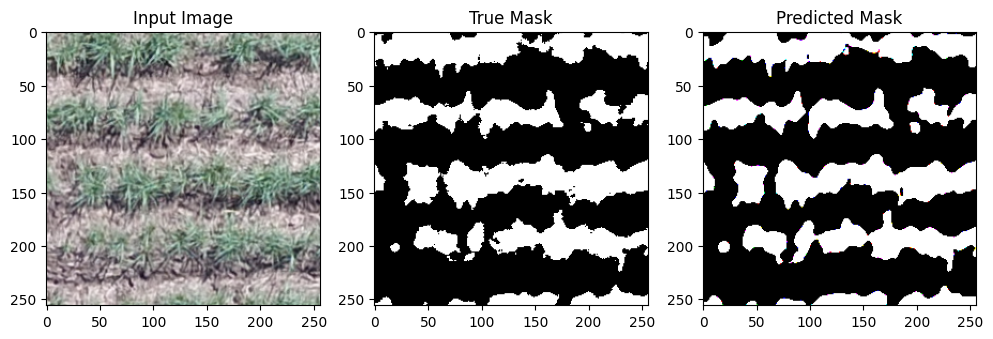

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


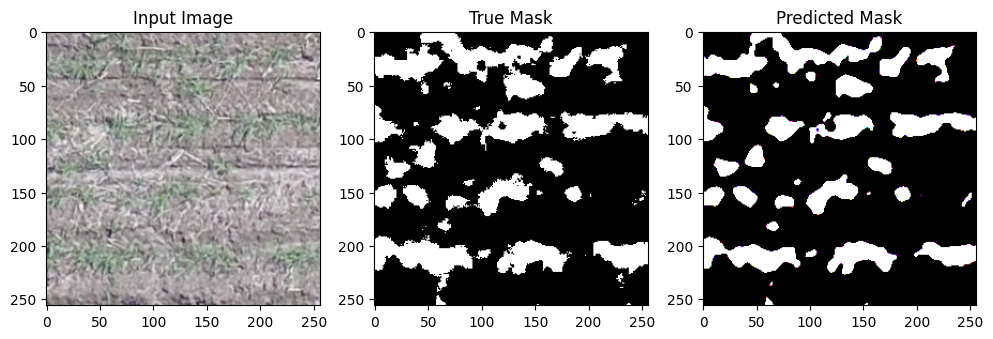

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


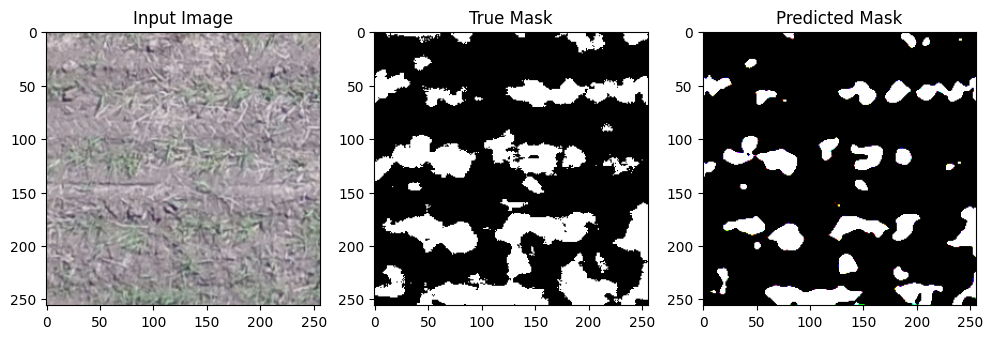

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


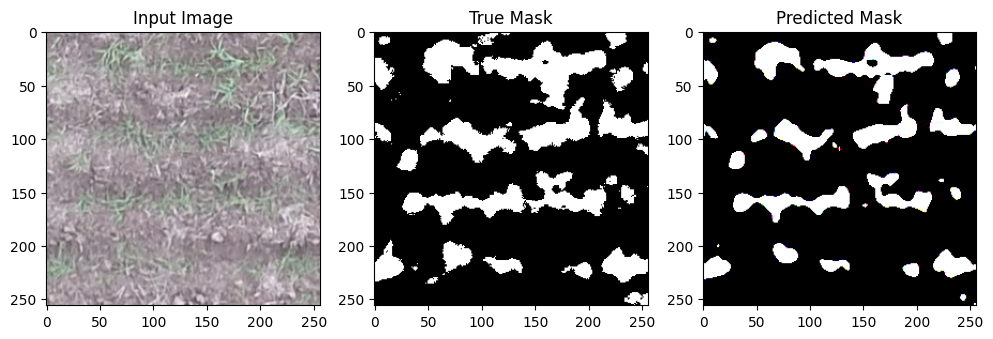

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


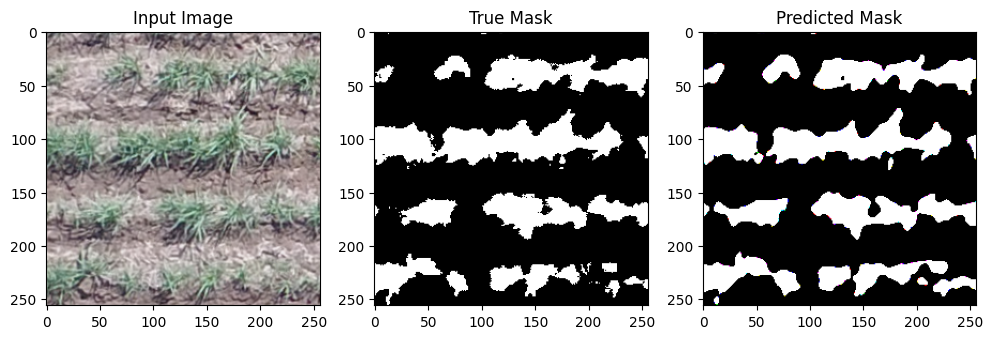

In [32]:
model.evaluate(X_val, y_val)

# Visualização de algumas previsões
def visualize_predictions(model, X, y, num=5):
    for i in range(num):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_mask = y[idx]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img)
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(true_mask, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.show()

visualize_predictions(model, X_val, y_val)